# Time series analysis
 Lund University

### Example code 7: transfer function example. This is an IMPORTANT example!

 Note that Matlab uses a slightly different notation for the BJ model as
 compared to that used in the course. In Matlab's notation:

    A(z) y(t) = [B(z)/F(z)] u(t) + [C(z)/D(z)] e(t)

 This means that:

   A(z) = 1,       B(z) = B(z),    F(z) = A2(z)
   C(z) = C1(z),   D(z) = A1(z)

**Reference:**  
*An Introduction to Time Series Modeling*, 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

Lets have fun!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.join('..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main'))

from tsa_lth.modelling import estimateARMA, estimateBJ, PEM, filter as tsa_filter
from tsa_lth.analysis import plotACFnPACF

In [2]:
np.random.seed(50)  # Set the seed (just done for the lecture!) 
# Simulate some processes.
C1 = np.array([1, 0.4, 0, 0.6])
A1 = np.array([1, -0.4, 0.8])
C3 = np.array([1, 0, 0, 0.8])
A3 = np.array([1, 0.9])
B = np.array([0, 0, 2, 0, -0.8])
A2 = np.array([1])
noLags = 30  # Number of lags shown for ACF and PACF.

# Generate the noise and the input signals.
N = 1000  # Try reducing the number of available samples to N=100. What happens? How many samples do you need to get a white residual even with the true model?
extraN = 100  # Add some intial samples to avoid initiation effects.
z = tsa_filter(C1, A1, np.random.randn(N + extraN), remove=False)  # This is the noise model.
x = tsa_filter(C3, A3, np.random.randn(N + extraN), remove=False)  # This is the input signal.

# Form the output using the filtered input. Remove the initial samples.
u = tsa_filter(B, A2, x, remove=False)  # This is the influence of the input on the output.
y = u + z  # Form the observed signal.

# Remove the extra samples added to avoid initiation effects.
y = y[extraN:]
x = x[extraN:]
u = u[extraN:]

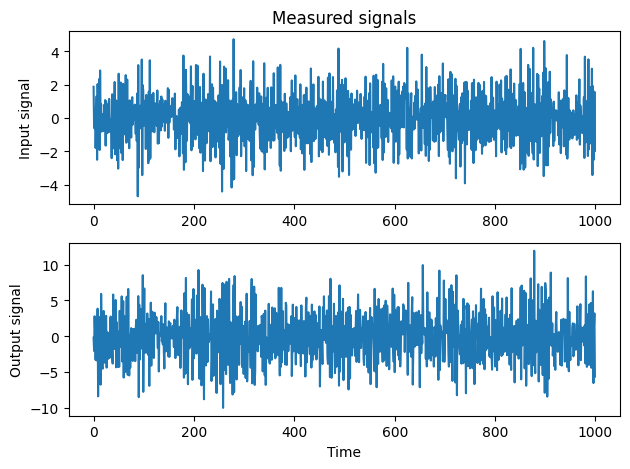

In [3]:
# Examine the data.
plt.figure()
plt.subplot(211)
plt.plot(x)
plt.ylabel('Input signal')
plt.title('Measured signals')
plt.subplot(212)
plt.plot(y)
plt.ylabel('Output signal')
plt.xlabel('Time')
plt.tight_layout()
plt.show()

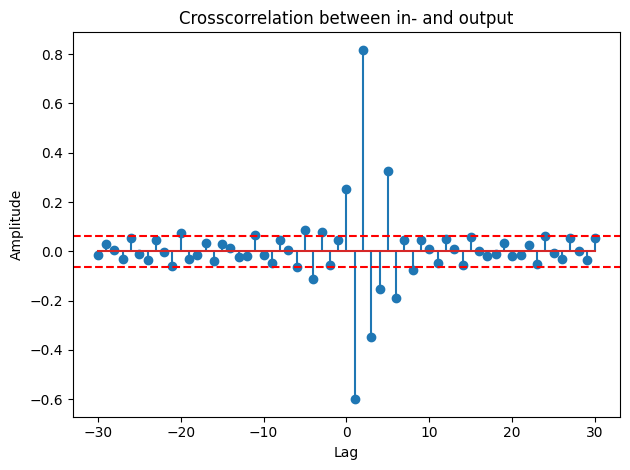

In [4]:
Cxy = np.correlate(y - np.mean(y), x - np.mean(x), mode='full')
Cxy = Cxy / (np.std(y) * np.std(x) * len(y))
lags = np.arange(-noLags, noLags + 1)
mid = len(Cxy) // 2
Cxy = Cxy[mid - noLags:mid + noLags + 1]

plt.figure()
plt.stem(lags, Cxy)
condInt = 2 / np.sqrt(len(y))
plt.axhline(condInt, color='r', linestyle='--')
plt.axhline(-condInt, color='r', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.title('Crosscorrelation between in- and output')
plt.tight_layout()
plt.show()

## Begin with constructing a model for the input signal.

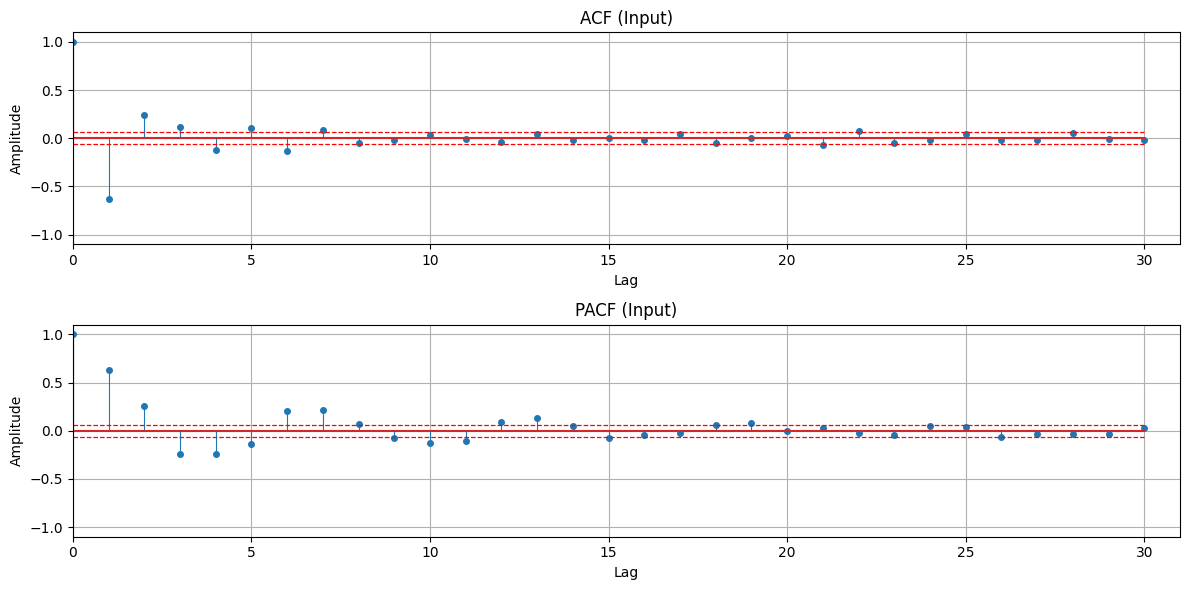

In [5]:
plotACFnPACF(x, noLags, 'Input', includeZeroLag=True)

## Estimate a first model for the input
The AR part has a strong dependency at lag 1 and 3, lets begin with that.

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 + 0.697(±0.0237)·z⁻¹ - 0.2804(±0.0237)·z⁻³

Polynomial orders: nA = 3
Number of free coefficients: 2
Fit to estimation data (NRMSE): 27.25%
FPE : 1.292  MSE : 1.287
AIC : 3085.003   BIC : 3094.812



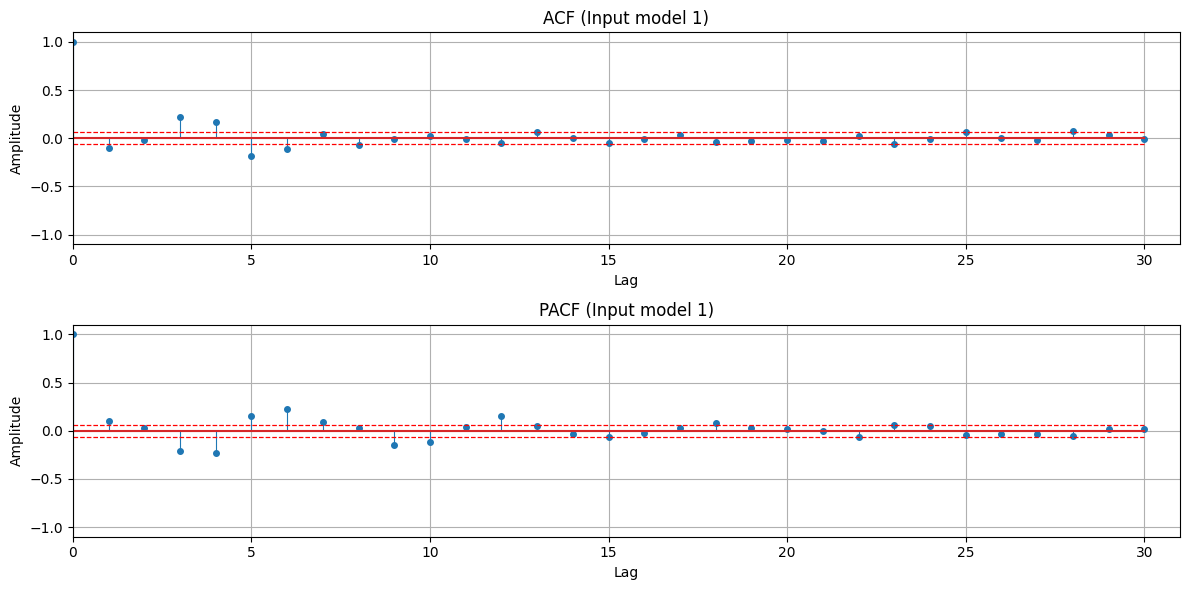

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 166.13 < 37.65)
  McLeod-Li test:        True (white if 34.66 < 37.65)
  Monti test:            False (white if 279.71 < 37.65)
  Sign change test:      True (white if 0.53 in [0.47,0.53])


In [6]:
estimateARMA(x, A=3, A_free=[1, 1, 0, 1], C=0, titleStr='Input model 1', noLags=noLags)

## Estimate a second model for the input
The MA part seems to have dependencies at lag 3 and 4. Lets add those.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 + 0.8723(±0.0237)·z⁻¹ + 0.0177(±0.0479)·z⁻³ + 0.0079(±0.036)·z⁻⁴
C(z) = 1.0 + 0.7969(±0.031)·z⁻³ - 0.0161(±0.0277)·z⁻⁴

Polynomial orders: nA = 4    nC = 4
Number of free coefficients: 5
Fit to estimation data (NRMSE): 35.86%
FPE : 1.011  MSE : 1.0
AIC : 2836.988   BIC : 2861.507



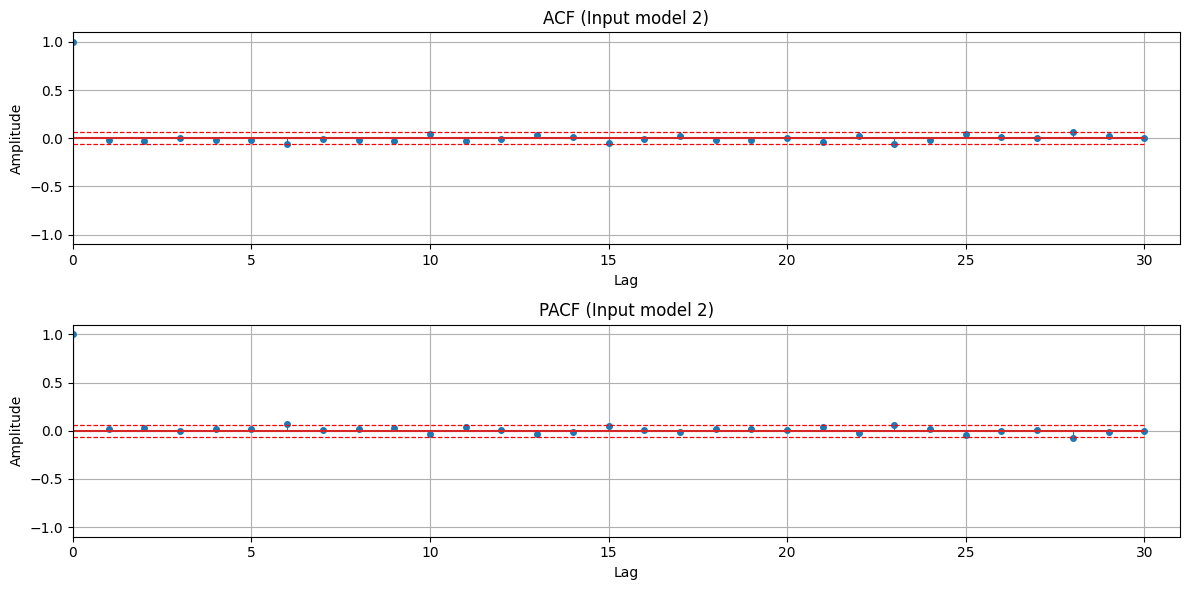

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 22.70 < 37.65)
  McLeod-Li test:        True (white if 27.33 < 37.65)
  Monti test:            True (white if 23.93 < 37.65)
  Sign change test:      True (white if 0.50 in [0.47,0.53])


In [7]:
estimateARMA(x, A=4, A_free=[0, 1, 0, 1, 1], C=4, C_free=[0, 0, 0, 1, 1], titleStr='Input model 2', noLags=noLags)

## Estimate a third model for the input
It is now white, but notice that two AR coefficienta - and the last MA coefficient - do not seem to be significant, lets try to remove c4. Is the residual still white?

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 + 0.8715(±0.0237)·z⁻¹ + 0.0115(±0.0459)·z⁻³ + 0.0133(±0.0355)·z⁻⁴
C(z) = 1.0 + 0.7907(±0.0281)·z⁻³

Polynomial orders: nA = 4    nC = 3
Number of free coefficients: 4
Fit to estimation data (NRMSE): 35.85%
FPE : 1.009  MSE : 1.001
AIC : 2835.289   BIC : 2854.904



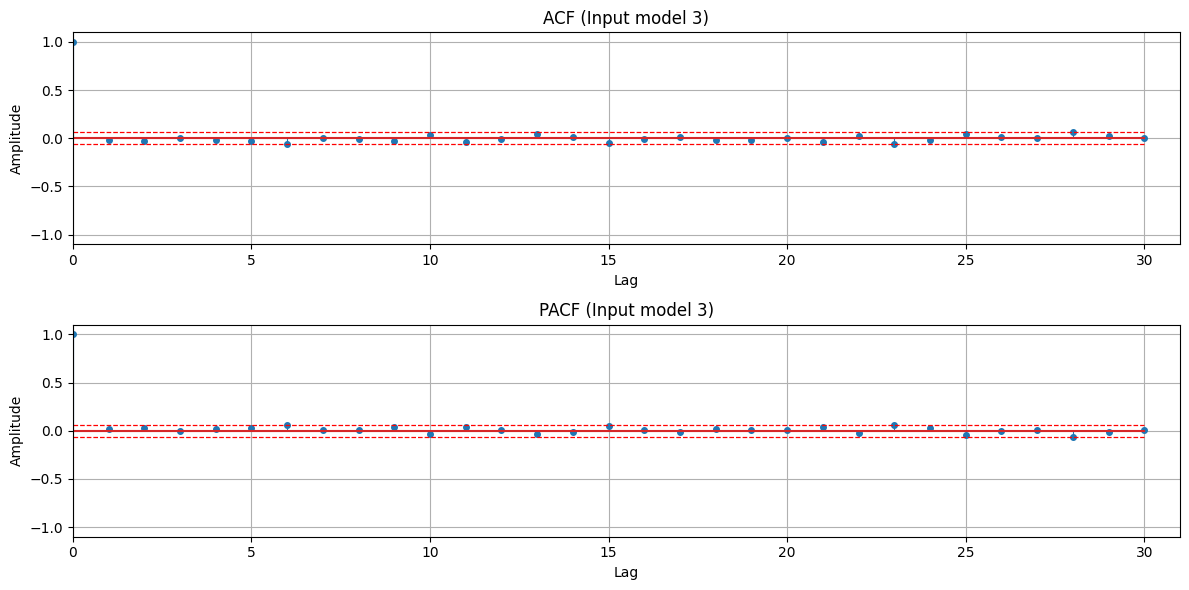

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 23.20 < 37.65)
  McLeod-Li test:        True (white if 27.49 < 37.65)
  Monti test:            True (white if 24.53 < 37.65)
  Sign change test:      True (white if 0.51 in [0.47,0.53])


In [8]:
estimateARMA(x, A=4, A_free=[0, 1, 0, 1, 1], C=3, C_free=[0, 0, 0, 1], titleStr='Input model 3', noLags=noLags)

## Estimate a fourth model for the input
Can we cut the two AR components too? Note how the resulting model compares with the model we used to simulate the input.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 + 0.8685(±0.0179)·z⁻¹
C(z) = 1.0 + 0.7856(±0.0224)·z⁻³

Polynomial orders: nA = 1    nC = 3
Number of free coefficients: 2
Fit to estimation data (NRMSE): 35.8%
FPE : 1.006  MSE : 1.002
AIC : 2841.323   BIC : 2851.136



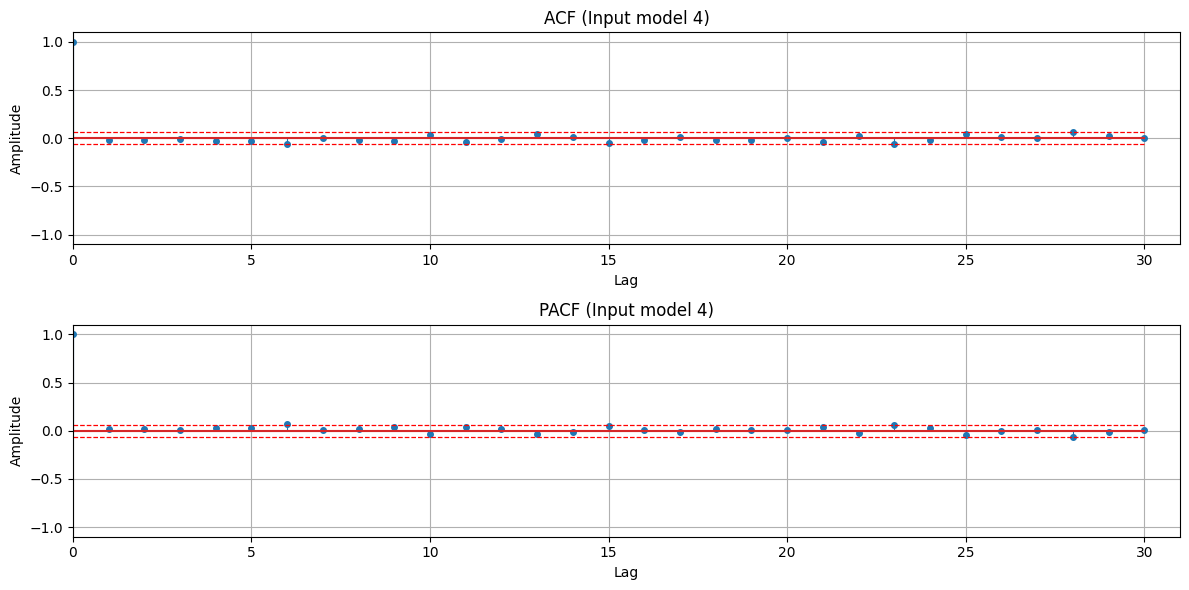

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 23.60 < 37.65)
  McLeod-Li test:        True (white if 27.02 < 37.65)
  Monti test:            True (white if 25.57 < 37.65)
  Sign change test:      True (white if 0.51 in [0.47,0.53])


In [9]:
foundModel = estimateARMA(x, A=1, C=3, C_free=[0, 0, 0, 1], titleStr='Input model 4', noLags=noLags)

## Form the filtered signals and compute their cross-correlation.
Word of warning; if you get odd result, plot ex and ey and check to there are no transient effects, such as ringdown from the filtering, still in the residual. If so, just cut a few more samples.

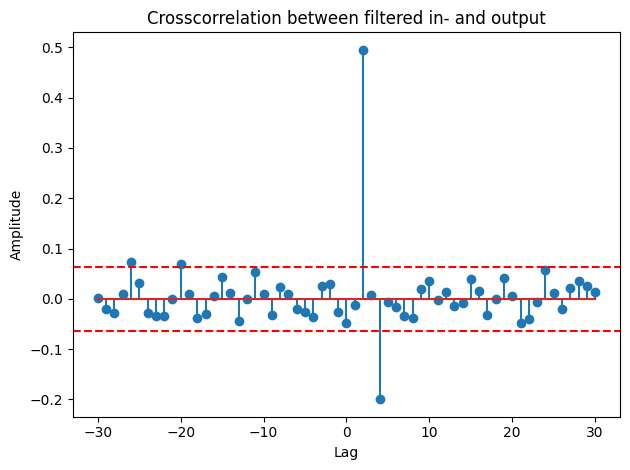

In [10]:
ex = tsa_filter(foundModel.A, foundModel.C, x, remove=False)
ey = tsa_filter(foundModel.A, foundModel.C, y, remove=False)
# Remove startup transient samples consistently using the fitted model's helper
rmv = foundModel.model._samps_to_remove()
ex = ex[rmv:]
ey = ey[rmv:]

Cxy = np.correlate(ey - np.mean(ey), ex - np.mean(ex), mode='full')
Cxy = Cxy / (np.std(ey) * np.std(ex) * len(ey))
lags = np.arange(-noLags, noLags + 1)
mid = len(Cxy) // 2
Cxy = Cxy[mid - noLags:mid + noLags + 1]

plt.figure()
plt.stem(lags, Cxy)
condInt = 2 / np.sqrt(len(ey))
plt.axhline(condInt, color='r', linestyle='--')
plt.axhline(-condInt, color='r', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.title('Crosscorrelation between filtered in- and output')
plt.tight_layout()
plt.show()
# Suggests a delay of d=2 and a filter of length 3 (but missing the second
# lag). This implies s=2 (recall d+s). There does not seem to be much of a
# decay, so lets try r=0.

## Form a first model using the transfer model.
The function call is estimateBJ( y, x, C1, A1, B, A2, titleStr, noLags )

Discrete-time BJ model: y(t) = B(z)x(t) + e(t)

B(z) = 2.0079(±0.0326)·z⁻² - 0.8141(±0.0326)·z⁻⁴

Polynomial orders: nB = 4
Number of free coefficients: 2
Fit to estimation data (NRMSE): 54.89%
FPE : 2.434  MSE : 2.426
AIC : 3713.296   BIC : 3723.103



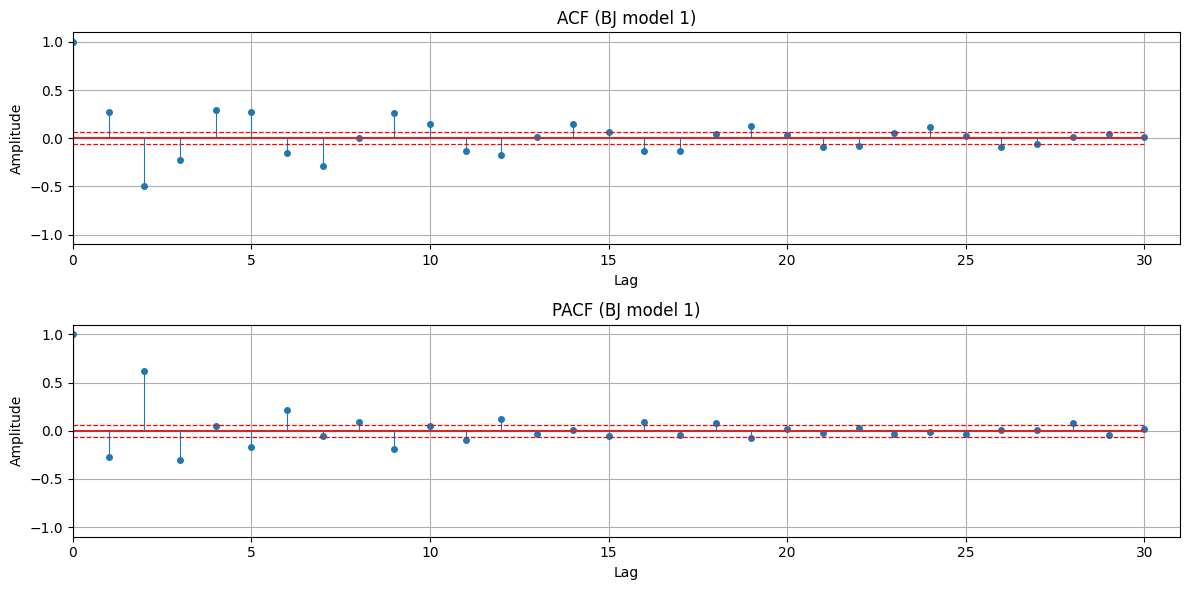

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 904.69 < 37.65)
  McLeod-Li test:        False (white if 106.15 < 37.65)
  Monti test:            False (white if 736.50 < 37.65)
  Sign change test:      False (white if 0.42 in [0.47,0.53])


In [11]:
estimateBJ(y, x, B=[0, 0, 1, 0, 1], B_free=[False, False, True, False, True], A2=[1], C1=[1], A1=[1], titleStr='BJ model 1', noLags=noLags)
# There seems to be strong dependencies for the first 3 AR lag, lets add them.

## Form a second model using the transfer model.


Discrete-time BJ model: y(t) = B(z)x(t) + [1/D(z)]e(t)

B(z) = 1.9924(±0.0131)·z⁻² - 0.7897(±0.0131)·z⁻⁴
D(z) = 1.0 - 0.6398(±0.0302)·z⁻¹ + 0.7595(±0.0272)·z⁻² - 0.3039(±0.0301)·z⁻³

Polynomial orders: nB = 4    nD = 3
Number of free coefficients: 5
Fit to estimation data (NRMSE): 67.71%
FPE : 1.255  MSE : 1.244
AIC : 3053.689   BIC : 3078.208



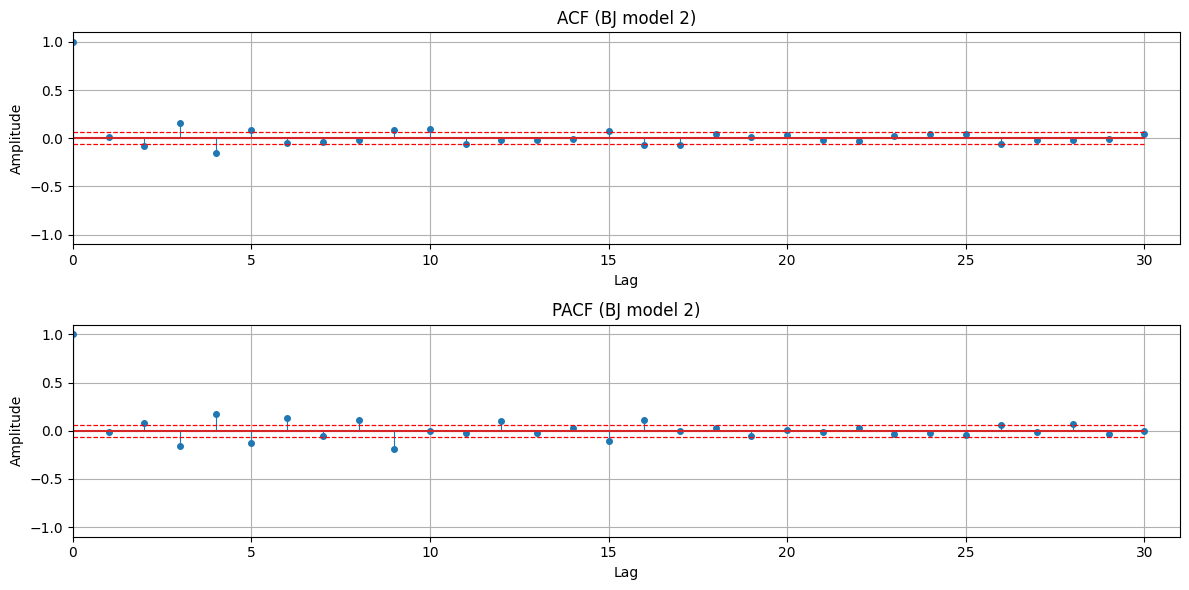

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 108.91 < 37.65)
  McLeod-Li test:        True (white if 27.31 < 37.65)
  Monti test:            False (white if 189.77 < 37.65)
  Sign change test:      True (white if 0.51 in [0.47,0.53])


In [12]:
estimateBJ(y, x, B=[0, 0, 1, 0, 1], B_free=[False, False, True, False, True], A2=[1], C1=[1], A1=3, titleStr='BJ model 2', noLags=noLags)
# Both B coefficients are statistically significant. There is some MA
# dependency at lag 3 and possibly 4. Lets try with just the third lag.

## Form a third model using the transfer model.
The function call is estimateBJ( y, x, C1, A1, B, A2, titleStr, noLags )

Discrete-time BJ model: y(t) = B(z)x(t) + [C(z)/D(z)]e(t)

B(z) = 1.9931(±0.0123)·z⁻² - 0.787(±0.0124)·z⁻⁴
C(z) = 1.0 + 0.598(±0.0391)·z⁻³
D(z) = 1.0 - 0.769(±0.0312)·z⁻¹ + 0.9203(±0.0272)·z⁻² - 0.1745(±0.0354)·z⁻³

Polynomial orders: nB = 4    nC = 3    nD = 3
Number of free coefficients: 6
Fit to estimation data (NRMSE): 69.49%
FPE : 1.123  MSE : 1.11
AIC : 2942.203   BIC : 2971.625



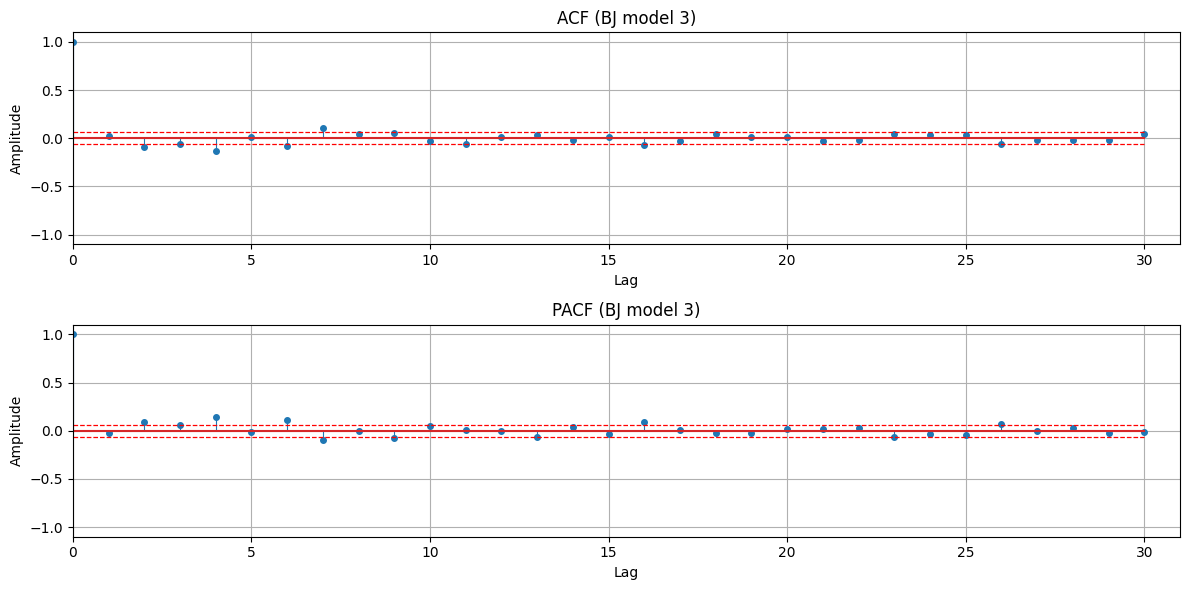

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 70.36 < 37.65)
  McLeod-Li test:        True (white if 29.78 < 37.65)
  Monti test:            False (white if 87.44 < 37.65)
  Sign change test:      True (white if 0.50 in [0.47,0.53])


In [13]:
estimateBJ(y, x, B=[0, 0, 1, 0, 1], B_free=[False, False, True, False, True], A2=[1], C1=3, C1_free=[False, False, False, True], A1=3, titleStr='BJ model 3', noLags=noLags)
# Seems that this was not enough - try adding the fourth as well.

## Form a fourth model using the transfer model.


Discrete-time BJ model: y(t) = B(z)x(t) + [C(z)/D(z)]e(t)

B(z) = 1.9926(±0.0121)·z⁻² - 0.7896(±0.0121)·z⁻⁴
C(z) = 1.0 + 0.6157(±0.0323)·z⁻³ - 0.2902(±0.0314)·z⁻⁴
D(z) = 1.0 - 0.7964(±0.0304)·z⁻¹ + 1.0457(±0.0234)·z⁻² - 0.2987(±0.0363)·z⁻³

Polynomial orders: nB = 4    nC = 4    nD = 3
Number of free coefficients: 7
Fit to estimation data (NRMSE): 70.68%
FPE : 1.039  MSE : 1.025
AIC : 2865.369   BIC : 2899.695



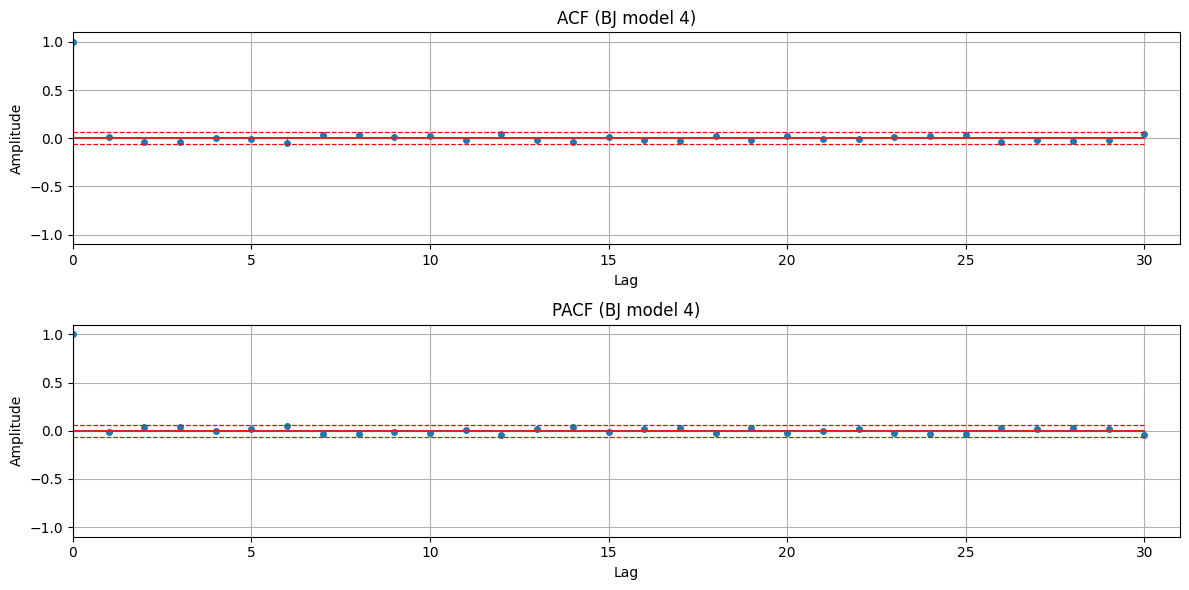

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 17.96 < 37.65)
  McLeod-Li test:        True (white if 31.87 < 37.65)
  Monti test:            True (white if 18.84 < 37.65)
  Sign change test:      True (white if 0.50 in [0.47,0.53])


In [14]:
foundModel = estimateBJ(y, x, B=[0, 0, 1, 0, 1], B_free=[False, False, True, False, True], A2=[1], C1=4, C1_free=[False, False, False, True, True], A1=3, titleStr='BJ model 4', noLags=noLags)
# Yes, now it seems to be white!!! :-)

## Check correlation of the resulting model.
Ideally, the residual formed as tilde_et = yt - [ B / A2 ] xt should be uncorrelated with xt. Lets check! All seems fine! Compare the resulting model with how the signal was generated.

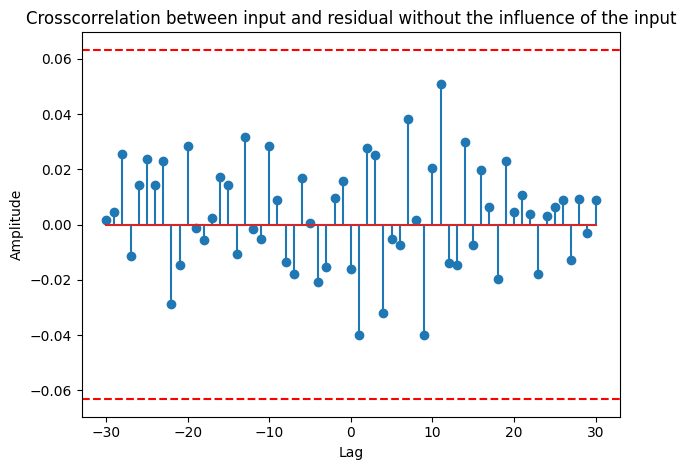

In [15]:
ut = tsa_filter(foundModel.B, foundModel.F, x, remove=False)
tilde_et = y - ut

# Remove startup transient samples consistently using model helper
rmv = foundModel.model._samps_to_remove()
tilde_et = tilde_et[rmv:]
tilde_xt = x[rmv:]
tilde_ut = ut[rmv:]

Cxy = np.correlate(tilde_xt - np.mean(tilde_xt), tilde_et - np.mean(tilde_et), mode='full')
Cxy = Cxy / (np.std(tilde_xt) * np.std(tilde_et) * len(tilde_xt))
lags = np.arange(-noLags, noLags + 1)
mid = len(Cxy) // 2
Cxy = Cxy[mid - noLags:mid + noLags + 1]

plt.figure()
plt.stem(lags, Cxy)
condInt = 2 / np.sqrt(len(y))
plt.axhline(condInt, color='r', linestyle='--')
plt.axhline(-condInt, color='r', linestyle='--')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.title('Crosscorrelation between input and residual without the influence of the input')
plt.tight_layout()
plt.show()

## What if we had used the correct model?
We did not reach the model we used to simulate the data - how does our model compare to the true model? Reflections?

Discrete-time BJ model: y(t) = B(z)x(t) + [C(z)/D(z)]e(t)

B(z) = 0.006(±0.0279) + 0.0055(±0.0505)·z⁻¹ + 1.9735(±0.0482)·z⁻² - 0.0351(±0.0505)·z⁻³ - 0.8063(±0.0279)·z⁻⁴
C(z) = 1.0 + 0.3938(±0.0456)·z⁻¹ + 0.0782(±0.0457)·z⁻² + 0.6165(±0.0433)·z⁻³
D(z) = 1.0 - 0.4399(±0.0323)·z⁻¹ + 0.8464(±0.0284)·z⁻²

Polynomial orders: nB = 4    nC = 3    nD = 2
Number of free coefficients: 10
Fit to estimation data (NRMSE): 70.67%
FPE : 1.046  MSE : 1.026
AIC : 2871.929   BIC : 2920.966



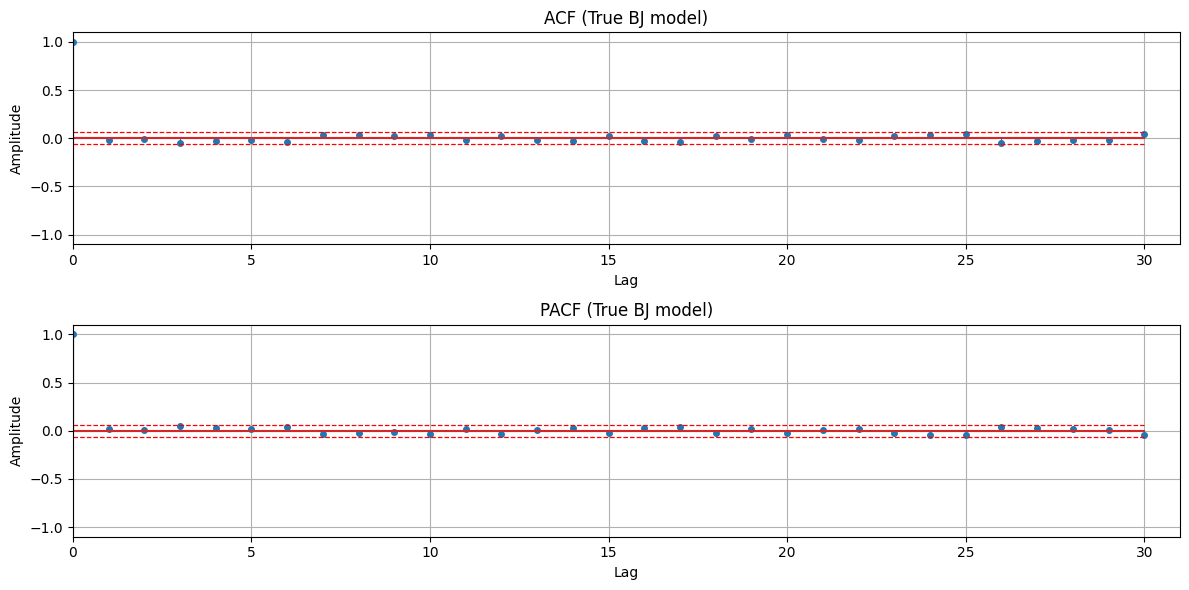

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 19.74 < 37.65)
  McLeod-Li test:        True (white if 34.92 < 37.65)
  Monti test:            True (white if 21.00 < 37.65)
  Sign change test:      True (white if 0.50 in [0.47,0.53])


In [16]:
foundModel2 = estimateBJ(y, x, B=B, C1=C1, A1=A1, A2=A2, titleStr='True BJ model', noLags=noLags)

## How well did we manage to capture the input?
Note that we manage to explain some of the noise as well. Beware if your model is such that the input does not explain much of the signal (and these seems correlated) - you have then not been able to use the input.

In [17]:
ut2 = tsa_filter(foundModel2.B, foundModel2.F, x, remove=False)
rmv2 = foundModel2.model._samps_to_remove()
t_ut = ut2[rmv2:]

print(f'\nThe variance of original signal is                           {np.var(y):.2f}.')
print(f'The variance explained by the input is                       {np.var(u):.2f}.')
print(f'Using the estimated model, the input explains                {np.var(tilde_ut):.2f}.')
print(f'Estimated using the true model structure, the input explains {np.var(t_ut):.2f}.')


The variance of original signal is                           11.92.
The variance explained by the input is                       9.42.
Using the estimated model, the input explains                9.36.
Estimated using the true model structure, the input explains 9.33.
